### Notebook Uses Networkx 1.11, Matplotlib 2.2.3, and a modified version of  tzyl/louvain-communities 

In [1]:
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from __future__ import division
import networkx as nx
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle as pl
import sys
import json


from pandas import Series, DataFrame
import pandas as pd
from louvain import detect_communities, modularity

In [3]:
##### Parameters
'''
tour_N = 25 #5
tour_c = 0
deg_def = [50]
flag_fn = 1 # 1 for g(v) = d(v) > 25, 4 for avg clustering coeff
'''

tour_N =  10 #5
tour_c = 0
deg_def = [10,4]
flag_fn = 1 # 1 for g(v) = d(v) > 10, 2 for g(v) = d(v) < 4, 3 for avg degree, 4 for avg clustering coeff
asy_var_MH_lesmis = [4.4154,14.93508,1.204e+03]
asy_var_RDS_lesmis = [1.1084,3.3240,272.7649]

max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
MH_do = 1 # Flag for doing MH simulation
RDS_do = 1 # Flag for doing RDS simulation
RDSRR_do = 1
MHRR_do = 1

SHOW_VAR_CONVG = 0
ABS_ERROR = 1

In [4]:
def node_fn(node):
    if flag_fn == 1:
        temp = int(G.degree(node)>deg_def[0])
    elif flag_fn == 2:
        temp = int(G.degree(node)<deg_def[1])
    elif flag_fn == 3:
        temp = G.degree(node)
    elif flag_fn == 4:
        deg = G.degree(node)
        if deg < 2:
            temp = 0
        else:
            temp = 2*nx.triangles(G,node)/(deg*(deg-1))
    else:
        print("Not a defined a function")
        sys.exit(0)
    return temp

In [5]:
#G = nx.read_edgelist("friendster_community1_trimmed.edgelist",nodetype = int)

data = json.loads(open('lm.json').read())
G = nx.Graph()
for n in data['nodes']:
    G.add_node(n['id'], group=n['group'])
for l in data['links']:
    G.add_edge(l['source'], l['target'])
#G = nx.les_miserables_graph()
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()

print(G_no_edges,G_no_nodes)

254 77


In [6]:
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes

In [7]:
def draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
    for x in range(len(pos)):
        pos[x] = pos[x]+np.array([0.02,0])
    labels = dict([(n, n) for n in G.nodes()]) #add labels
    _ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels

Modularity for best partition: 0.5555521111042241


/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


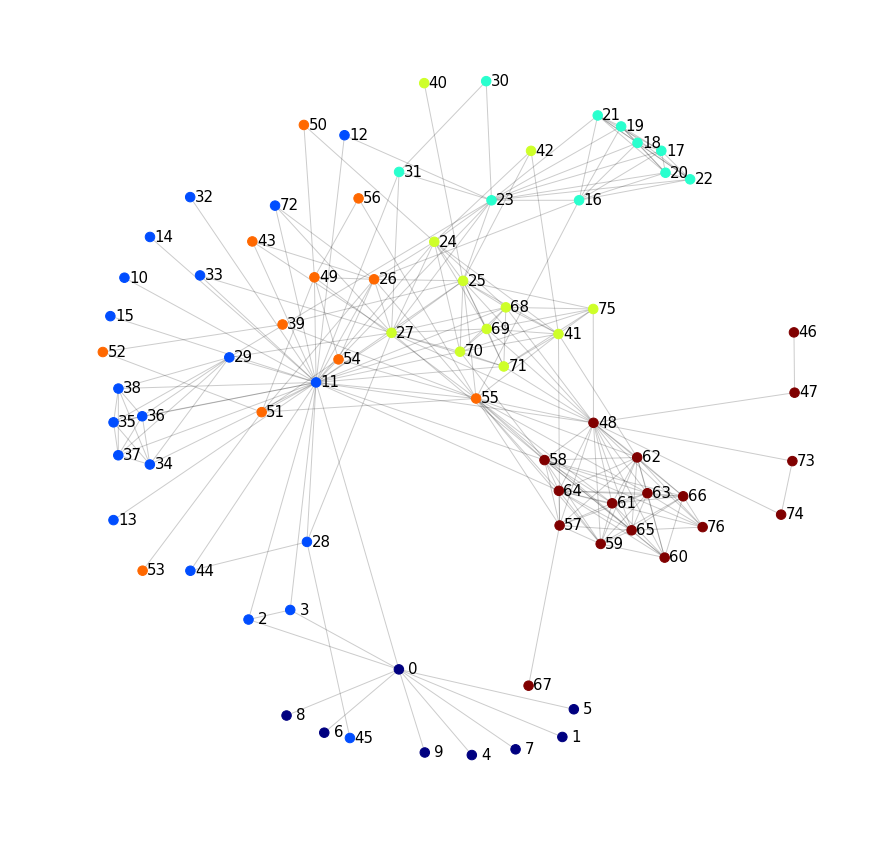

In [8]:
draw_communities(G)

In [9]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}

In [10]:
for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes
print(len(community_map))

6


In [11]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t
        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [12]:
def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample = random.choice(neighbors)
        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [13]:
def RDSRR_sampling(G,B,U=None):
    M = np.power(B,2/3)
    restart_ind = np.power(np.arange(1,M),1.5)
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [14]:
def MHRR_sampling(G,B,U=None):
    M = np.power(B,2/3)
    restart_ind = np.power(np.arange(1,M),1.5)
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample_t = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [15]:
U = [0,11,23,55,64,69]
print([node_map[x] for x in U])

[0, 1, 2, 4, 5, 3]


In [16]:
if MH_do:
    MSE_MH_t = 0
    for ii in range(1,no_runs+1):
        MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
    MSE_MH = MSE_MH_t/(no_runs)
    MSE_MH = np.sqrt(MSE_MH)/F_org

In [17]:
if RDS_do:
    MSE_rds_t = 0
    for ii in range(1,no_runs+1):
        MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
    MSE_rds = MSE_rds_t/(no_runs)
    MSE_rds = np.sqrt(MSE_rds)/F_org

In [18]:
if RDSRR_do:
    MSE_rdsrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
    MSE_rdsrr = MSE_rdsrr_t/(no_runs)
    MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

In [19]:
if MHRR_do:
    MSE_mhrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
    MSE_mhrr = MSE_mhrr_t/(no_runs)
    MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

In [20]:
if RDSRR_do:
    MSE_rdsrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
    MSE_rdsrr2 = MSE_rdsrr_t/(no_runs)
    MSE_rdsrr2 = np.sqrt(MSE_rdsrr2)/F_org

In [21]:
if MHRR_do:
    MSE_mhrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
    MSE_mhrr2 = MSE_mhrr_t/(no_runs)
    MSE_mhrr2 = np.sqrt(MSE_mhrr2)/F_org

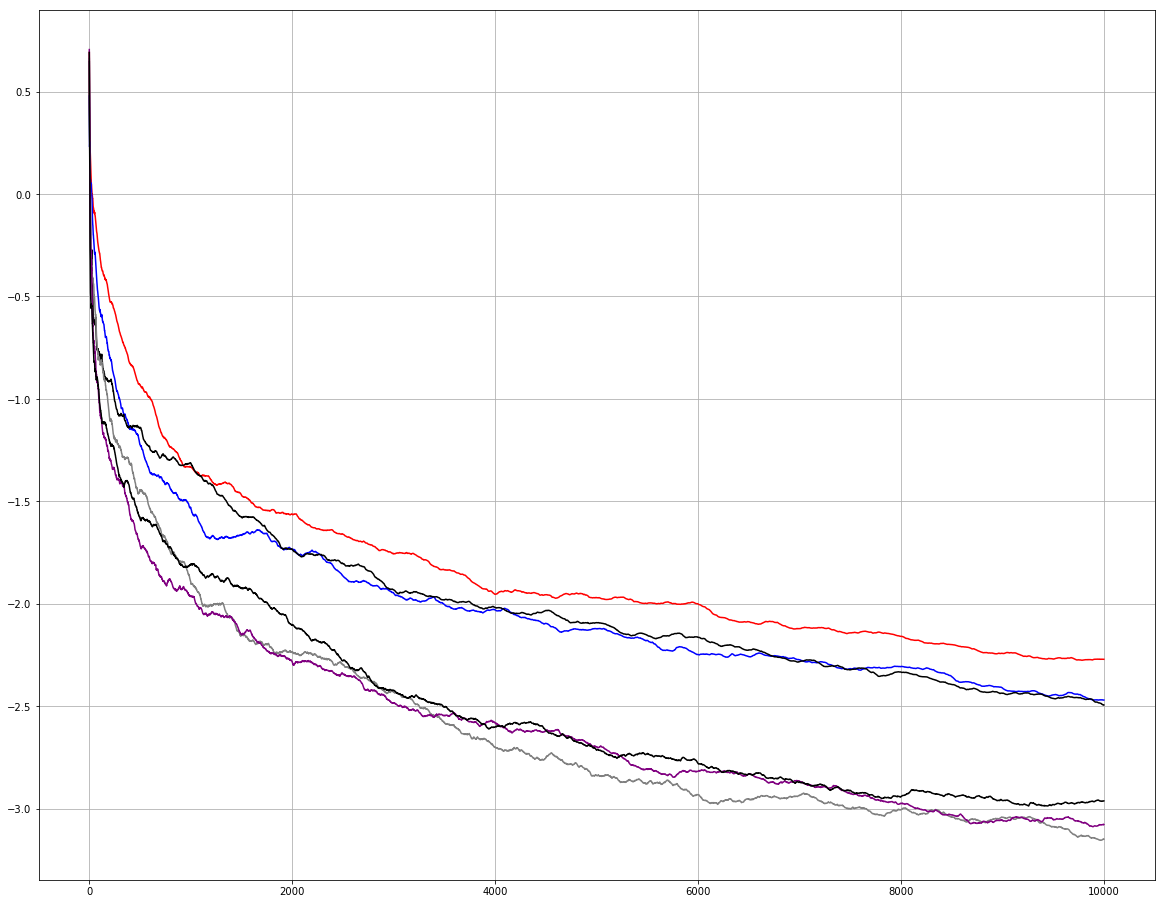

In [22]:
plt.figure(1,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr2)))),np.log(MSE_mhrr2),color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr2)))),np.log(MSE_rdsrr2),color='black',linewidth=1.5)
plt.grid()

In [23]:
flag_fn = 2 
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.42857142857142855


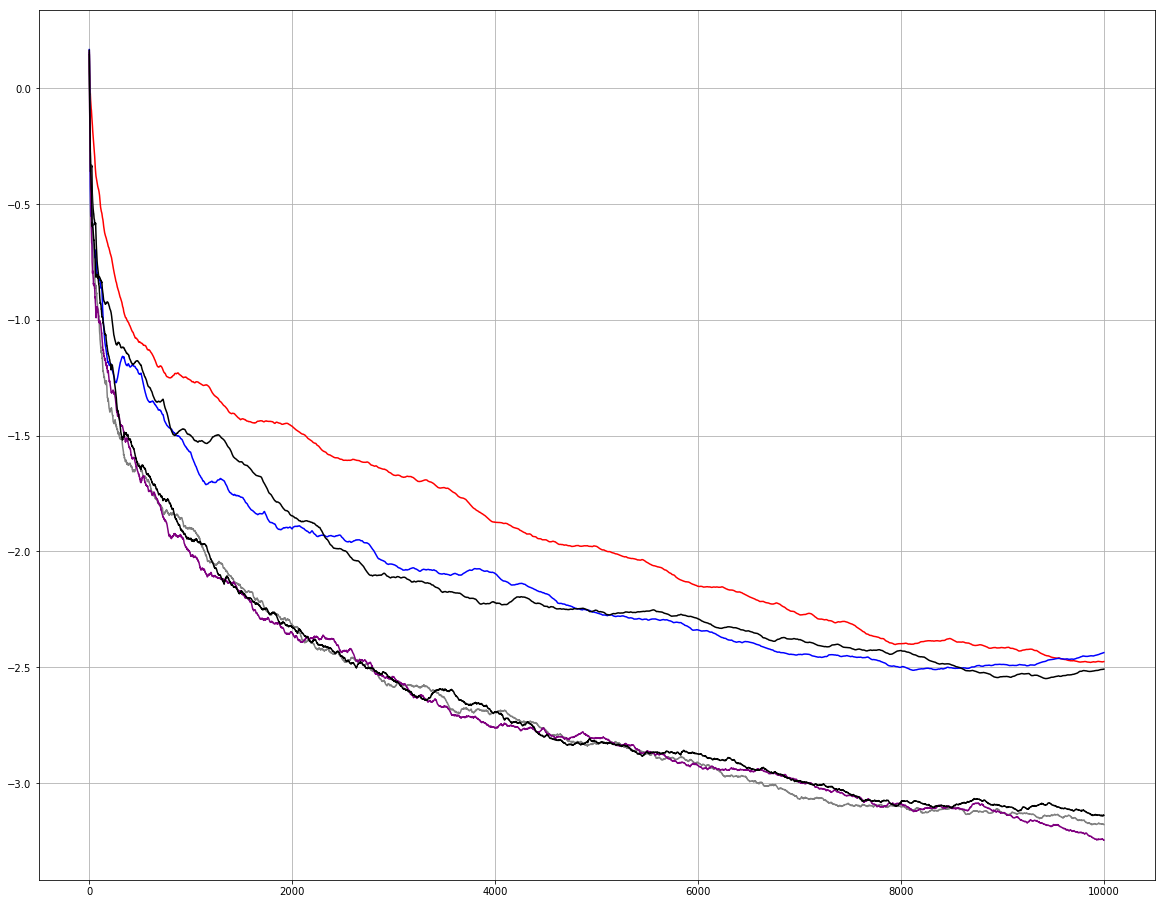

In [24]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr2 = MSE_rdsrr_t/(no_runs)
MSE_rdsrr2 = np.sqrt(MSE_rdsrr2)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr2 = MSE_mhrr_t/(no_runs)
MSE_mhrr2 = np.sqrt(MSE_mhrr2)/F_org

plt.figure(2,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr2)))),np.log(MSE_mhrr2),color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr2)))),np.log(MSE_rdsrr2),color='black',linewidth=1.5)
plt.grid()

In [25]:
flag_fn = 3 
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

6.597402597402597


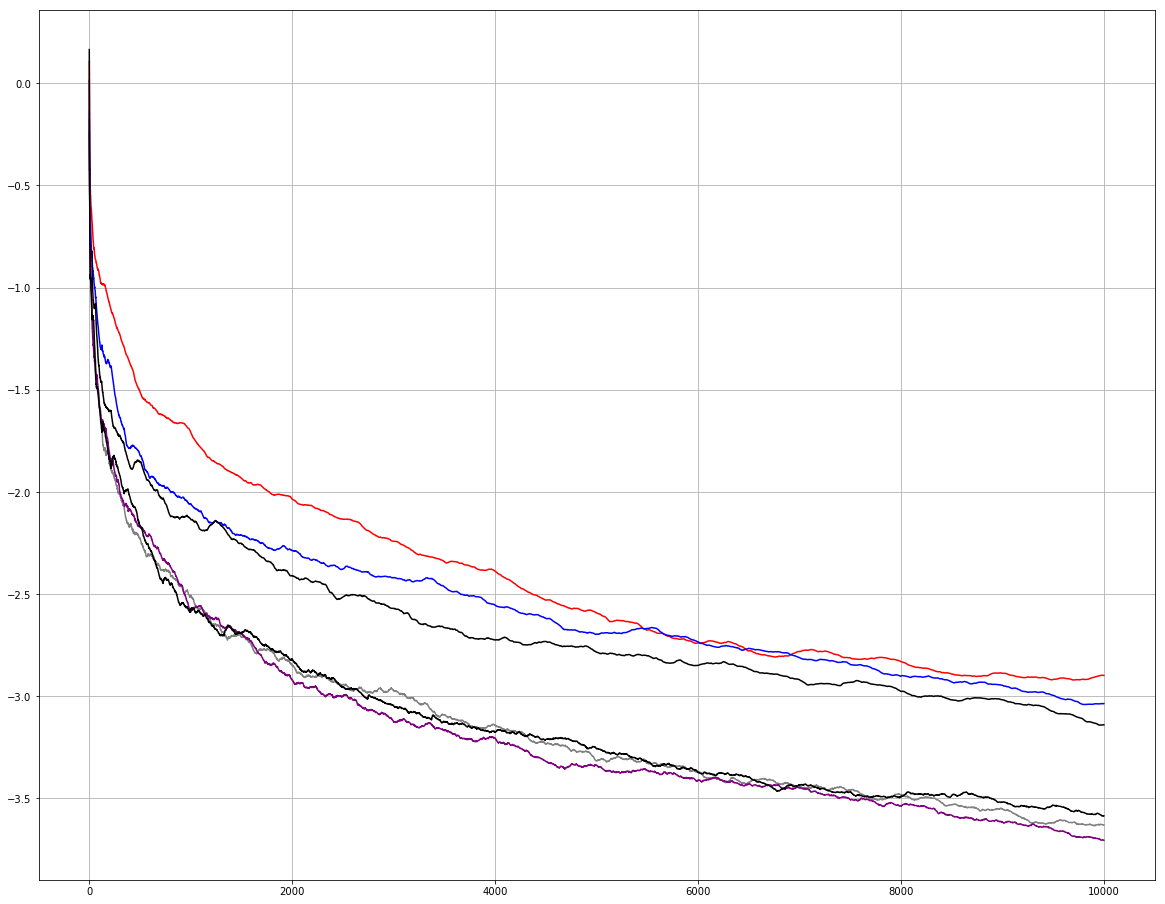

In [26]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr2 = MSE_rdsrr_t/(no_runs)
MSE_rdsrr2 = np.sqrt(MSE_rdsrr2)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr2 = MSE_mhrr_t/(no_runs)
MSE_mhrr2 = np.sqrt(MSE_mhrr2)/F_org

plt.figure(3,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr2)))),np.log(MSE_mhrr2),color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr2)))),np.log(MSE_rdsrr2),color='black',linewidth=1.5)
plt.grid()

In [27]:
flag_fn = 4
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.5731367499320135


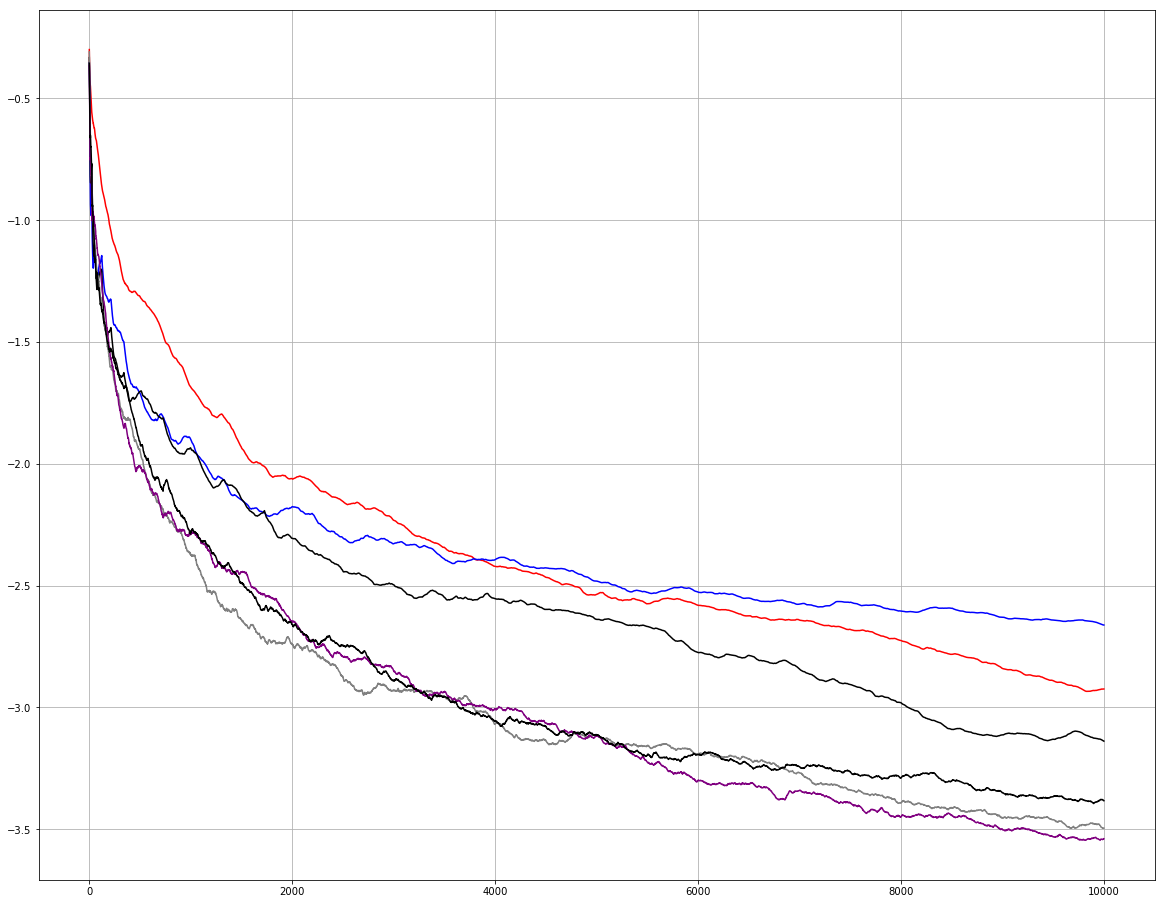

In [28]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B,U)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr2 = MSE_rdsrr_t/(no_runs)
MSE_rdsrr2 = np.sqrt(MSE_rdsrr2)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr2 = MSE_mhrr_t/(no_runs)
MSE_mhrr2 = np.sqrt(MSE_mhrr2)/F_org

plt.figure(3,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr2)))),np.log(MSE_mhrr2),color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr2)))),np.log(MSE_rdsrr2),color='black',linewidth=1.5)
plt.grid()